In [4]:
import scipy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

In [5]:
df = pd.read_csv('/Users/celinepham/Downloads/amz_uk_price_prediction_dataset.csv')
display(df)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


isBestSeller,False,True,ratio
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
...,...,...,...
"CD, Disc & Tape Players",8798,0,0.000000
General Music-Making Accessories,259,0,0.000000
Snowboard Boots,1449,0,0.000000


P-value : 0.0 is below 0.05, meaning there's a significant association between categories and best-seller. As such, we procede with Cramér's test.
 Cramer's V is: 0.1222829439760564, meaning there's a weak association between the variables


<Axes: xlabel='category'>

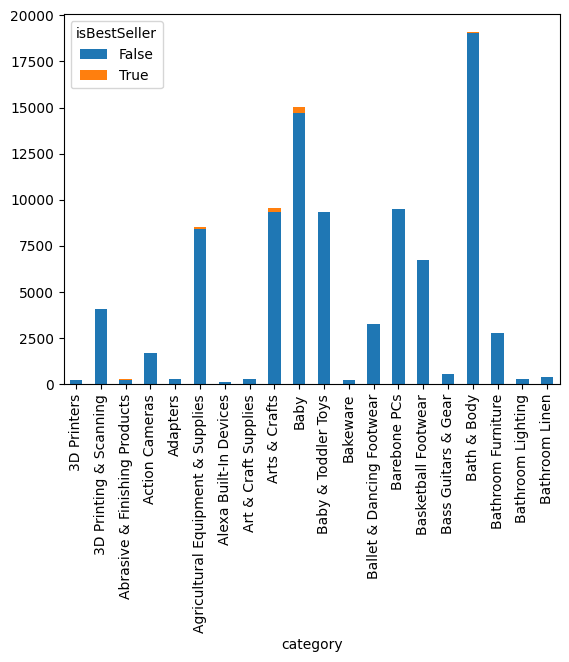

In [6]:
df.head(5)

# Generating a crosstab for 'category' and 'isBestSeller'
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])

column_False = crosstab_result[False]
column_True = crosstab_result[True]

crosstab_result["ratio"] = column_True / (column_True + column_False)

display(crosstab_result.sort_values(by="ratio", ascending = False))

# Crossing categories and best-seller status, we can see some categories that seem to have an higher ratio of BestSellers. Categories such as < Grocery >, < Smart Home > or < Health > seem to show
# a ratio of best sellers around 5%. 

# ChiSquared tests the independence of two categorical variables by comparing observed frequencies to expected frequencies.
# If p-value < 0.05 -> there is a significant association between the categorical variables.

# H0 : category and best seller are independent
# H1 : category and best seller are NOT independent

# testing for equality:
alpha = 0.05
crosstab_result = crosstab_result.drop("ratio", axis=1)

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

p_val = round(float(chi2_p_value),5)
if p_val < alpha:
    print(f"P-value : {p_val} is below {alpha}, meaning there's a significant association between categories and best-seller. As such, we procede with Cramér's test.")
    
    # Cramer's test measures the strength of the association between variables
    cramers = association(crosstab_result, method="cramer")
    if cramers == 0:
        print(f" Cramer's V is: {cramers}, meaning there's no association between the variables")
    elif cramers < 0.2:
        print(f" Cramer's V is: {cramers}, meaning there's a weak association between the variables")
    elif cramers < 0.6:
        print(f" Cramer's V is: {cramers}, meaning there's a moderate association between the variables")
    else:
        print(f" Cramer's V is: {cramers}, meaning there's a strong association between the variables")
    
else:
    print(f"P-value : {p_val} is above or equal to {alpha}, meaning there's no significant association between categories and best-seller")
    
crosstab_result.head(20).plot(kind="bar", stacked=True)

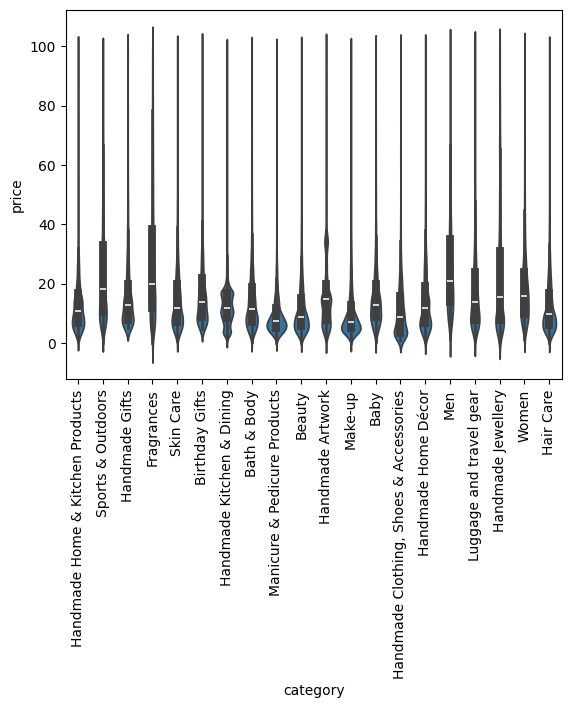

category
Desktop PCs       74.00
Boxing Shoes      69.79
Tablets           69.00
Graphics Cards    68.54
Motherboards      67.92
Name: price, dtype: float64

In [7]:
def tukeys_test_outliers(data, method="show"):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    if method== "show":
        return outliers
    
    elif method == "replace":
        median = data.median()
        data[outliers.index] = median
        return data
        
    elif method == "delete":
        index_drop = outliers.index
        data_no_outliers = data.drop(index_drop)
        
        return data_no_outliers
    
df_t = df.groupby("category")["price"].count().sort_values(ascending = False).head(20).index.to_list()

df["price"] = tukeys_test_outliers(df["price"], method="delete")

df_f = df[df["category"].isin(df_t)]

sns.violinplot(data=df_f, x='category', y='price')
plt.xticks(rotation=90)
plt.show()

df_median = df.groupby("category")["price"].median().sort_values(ascending = False).head(5)
display(df_median)

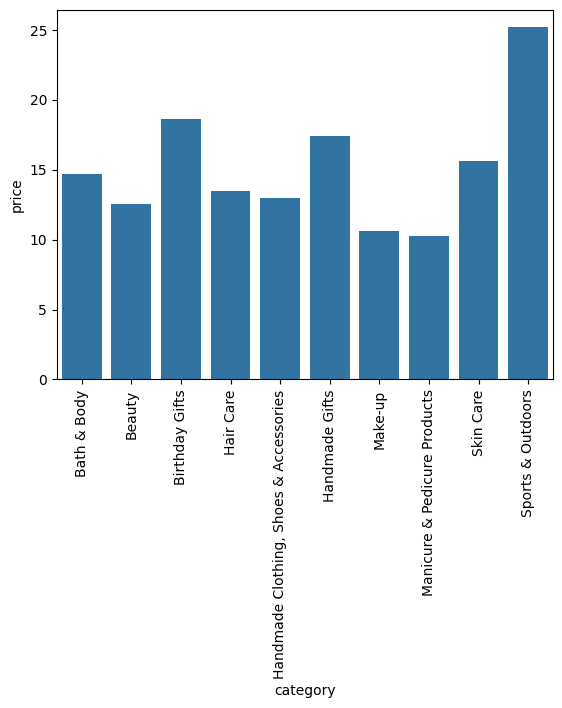

,category,price
190,Motherboards,68.772432


In [8]:
df_t10c = df.groupby("category")["price"].count().sort_values(ascending = False).head(10).index.to_list()
df_price_mean = df.groupby("category")["price"].mean().reset_index()

df_f_t10c = df_price_mean[df_price_mean["category"].isin(df_t10c)]
df_price_mean

sns.barplot(df_f_t10c, x = "category", y = "price")
plt.xticks(rotation=90)
plt.show()

df_price_mean.sort_values(by="price",ascending=False).head(1)

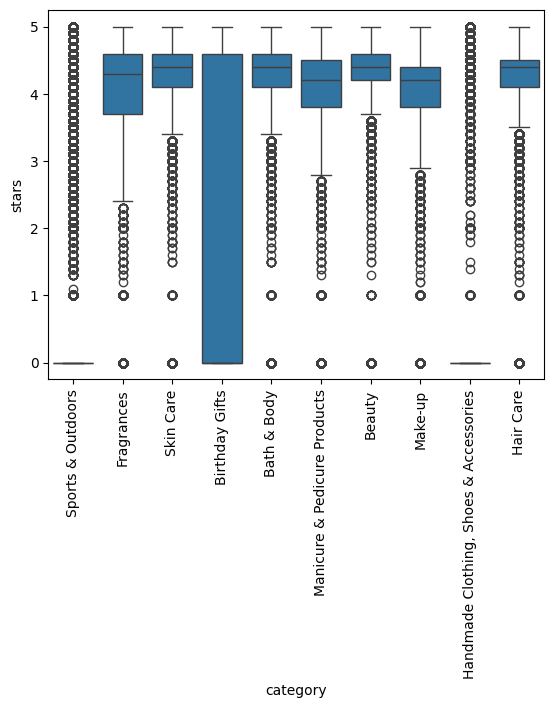

,category,stars
56,Computer Memory,4.7
132,Hobbies,4.6
25,"Beer, Wine & Spirits",4.6
164,Laptop Accessories,4.6
157,Kids' Play Figures,4.6
...,...,...
152,KVM Switches,0.0
153,Karaoke Equipment,0.0
163,Lab & Scientific Products,0.0
165,Laptops,0.0


In [9]:
df_s10c = df.groupby("category")["stars"].count().sort_values(ascending = False).head(10).index.to_list()
df_stars_median = df.groupby("category")["stars"].median().reset_index().sort_values(by="stars", ascending= False)

df_f_s10c = df[df["category"].isin(df_s10c)]

sns.boxplot(data=df_f_s10c, x='category', y='stars')
plt.xticks(rotation=90)
plt.show()

display(df_stars_median)

In [10]:
df_no_outliers = df.copy()

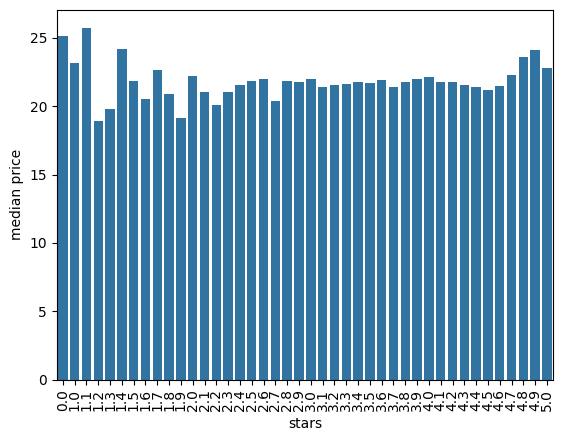

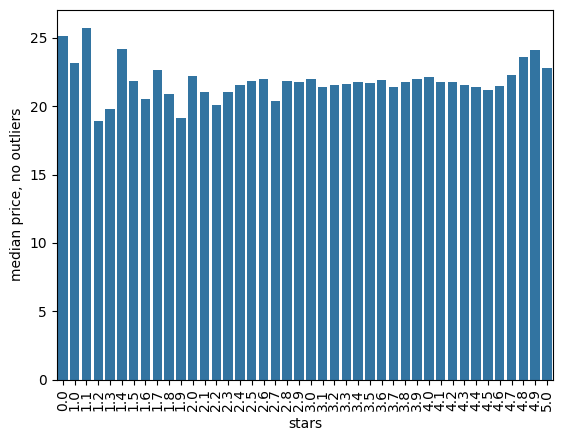

In [11]:
df_s10m = df.groupby("stars")["price"].mean().reset_index().sort_values(by="stars", ascending = False)
df_s10m_no = df_no_outliers.groupby("stars")["price"].mean().reset_index().sort_values(by="stars", ascending = False)
df_s10m


sns.barplot(df_s10m, x = "stars", y = "price")
plt.ylabel("median price")
plt.xticks(rotation=90)
plt.show()

sns.barplot(df_s10m_no, x = "stars", y = "price")
plt.ylabel("median price, no outliers")
plt.xticks(rotation=90)
plt.show()

In [12]:
# correlation with outliers
correlation_p = df['price'].corr(df['stars'])
correlation_s = df['price'].corr(df['stars'], method='spearman')
print(f"Pearson: {correlation_p} || Spearman: {correlation_s} with outliers.")

# correlation without outliers
correlation_p2 = df_no_outliers['price'].corr(df_no_outliers['stars'])
correlation_s2 = df_no_outliers['price'].corr(df_no_outliers['stars'], method='spearman')
print(f"Pearson: {correlation_p2} || Spearman: {correlation_s2} with no outliers.")

Pearson: -0.07767299878181001 || Spearman: -0.06679697280769055 with outliers.
Pearson: -0.07767299878181001 || Spearman: -0.06679697280769055 with no outliers.


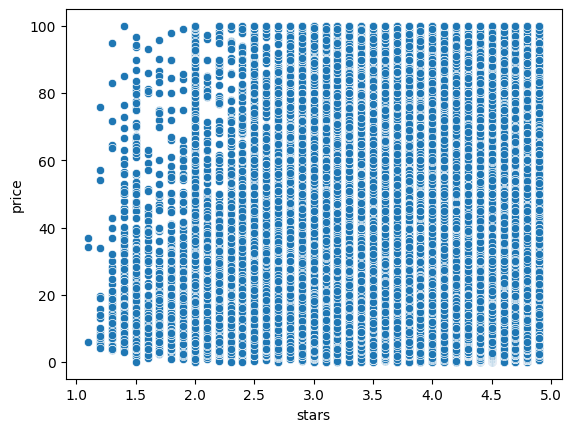

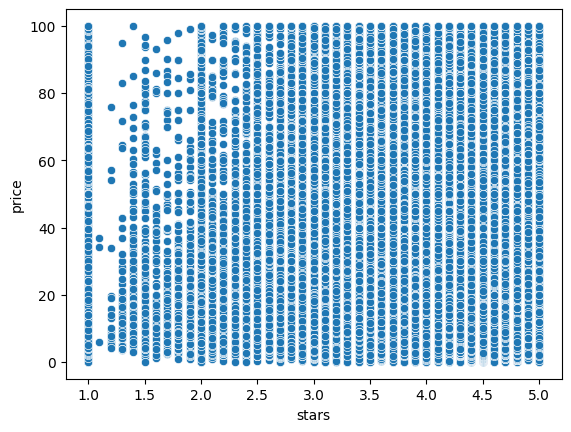

In [14]:
#outliers
df_excl = df[(df["stars"] > 1) & (df["stars"] < 5)] 

sns.scatterplot(df_excl, x = "stars", y='price')
plt.show()

#no outliers
df_excl2 = df_no_outliers[df_no_outliers["stars"] > 0] 

sns.scatterplot(df_excl2, x = "stars", y='price')
plt.show()

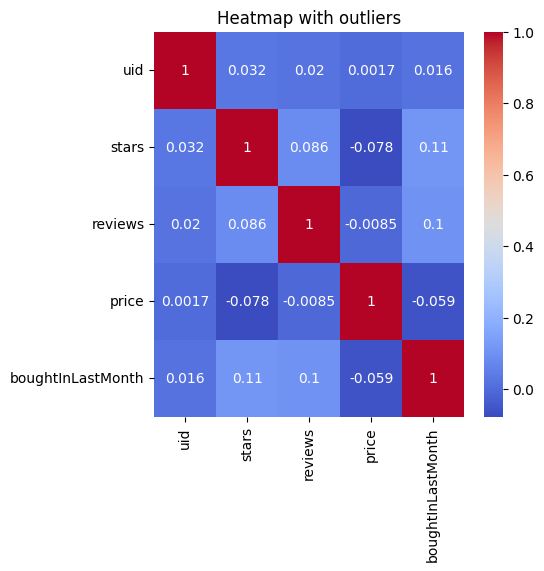

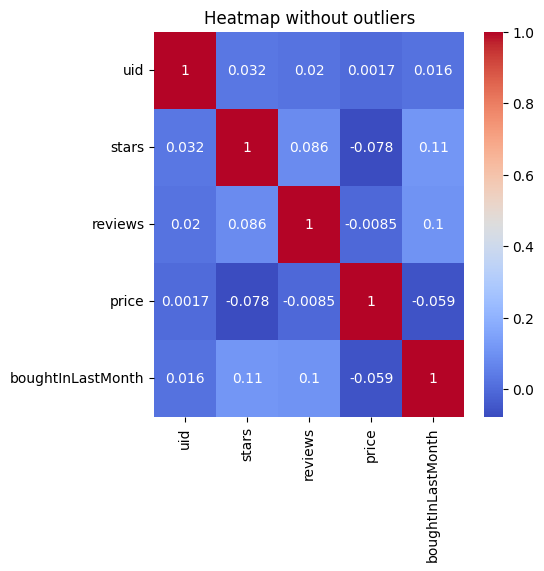

In [15]:
df_numerical = df.select_dtypes("number")
df_numerical_no = df_no_outliers.select_dtypes("number")
correlation_matrix = df_numerical.corr()
correlation_matrix2 = df_numerical_no.corr()


plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Heatmap with outliers")
plt.show()

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix2, annot=True, cmap="coolwarm")
plt.title("Heatmap without outliers")
plt.show()

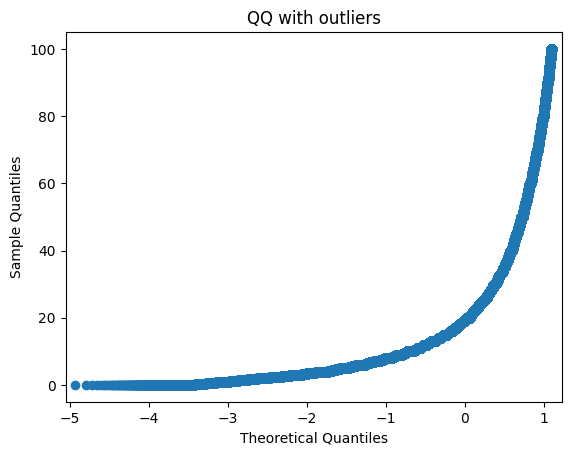

In [16]:
import statsmodels.api as sm

sm.qqplot(df['price'], line='s')
plt.title("QQ with outliers")
plt.show()